# MSE_test and MSE_train as function of model complexity

In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import numpy as np

Seed value:  0
Seed value:  1
Seed value:  2
Seed value:  3
Seed value:  4
Seed value:  5
Seed value:  6
Seed value:  7
Seed value:  8
Seed value:  9
Seed value:  10
Seed value:  11


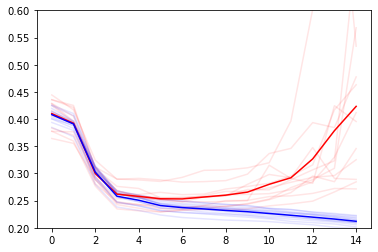

In [4]:
from franke_function import FrankeFunction as Fr
from regression import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 50) # lite: 50, stort: 500
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

poly = 16
MSE_test_list = []
MSE_train_list = []

for n in range(12): #loop thru 15 first seed values
    print("Seed value: ", str(n))
    np.random.seed(n) # Results is highly sensitive to seed choice, for thru different seed values? 
    noise = np.random.randn(x.shape[0], x.shape[1])
    z = Fr(x, y) + noise*np.var(Fr(x, y))*2
    
    scaler = StandardScaler() 
    x_cent = scaler.fit_transform(x.reshape(-1, 1)) #could be done outside loop, here for readability
    y_cent = scaler.fit_transform(y.reshape(-1, 1)) #could be done outside loop, here for readability
    z_cent = scaler.fit_transform(z.reshape(-1, 1))

    xy_cent_train, xy_cent_test, z_cent_train, z_cent_test = train_test_split(np.hstack([x_cent, y_cent]),
                                                                          z_cent, test_size=0.2)
    MSE_test = []
    MSE_train = []
    for poly_deg in range(1, poly):
        model = OLS(xy_cent_train[:, 0].ravel(), xy_cent_train[:, 1].ravel(), z_cent_train.ravel(), poly_deg)
    
        MSE_test.append(model.MSE(xy_cent_test[:, 0], xy_cent_test[:, 1], z_cent_test.ravel()))
        MSE_train.append(model.MSE(xy_cent_train[:, 0], xy_cent_train[:, 1], z_cent_train.ravel())) # orig model.
    
    plt.plot(MSE_test, 'r', alpha=0.1) # test settet gir alltid litt verre estimat ser det ut til
    plt.plot(MSE_train, 'b', alpha=0.1) 
    
    MSE_test_list.append(MSE_test) # sore all values for averaging
    MSE_train_list.append(MSE_train)
    
MSE_test_list = np.array(MSE_test_list)
MSE_train_list = np.array(MSE_train_list)

test_pol_avrg = np.mean(MSE_test_list, axis=0)
train_pol_avrg = np.mean(MSE_train_list, axis=0)

plt.plot(test_pol_avrg, 'r')
plt.plot(train_pol_avrg, 'b')

plt.ylim(0.2, 0.6)
plt.show()
# Observasjonar: 
# Med høyoppløslig grid må eg ha mer støy for at bias variance tradeoff skal oppdages
# Dette kan ha med at med høyoppløslig grid så tvinges funksjonen i større grad å forholde seg til F(x, y)
# , ikkje til støy. (må svinge mykje for å nå alle punkter når dei ligg tettere)Ein kan sjå for seg ein scatter 
#med tett i tett med punkter eller spredde punkter. Dersom  
# pukta ligg tett treng ein meir støy for at polynomet skal over-tilpasse seg. 

# I oppgava: Utled bias variance relation!

In [31]:
(1/(Fr(x, y).size - 1)) * np.sum((Fr(x, y) - np.mean(Fr(x, y)))**2)

0.08251793103703291

# Bootstrap - Reconstructing real world variance

We are bootstrapping out of the depths! Now on number: 0/20
We are bootstrapping out of the depths! Now on number: 1/20
We are bootstrapping out of the depths! Now on number: 2/20
We are bootstrapping out of the depths! Now on number: 3/20
We are bootstrapping out of the depths! Now on number: 4/20
We are bootstrapping out of the depths! Now on number: 5/20
We are bootstrapping out of the depths! Now on number: 6/20
We are bootstrapping out of the depths! Now on number: 7/20
We are bootstrapping out of the depths! Now on number: 8/20
We are bootstrapping out of the depths! Now on number: 9/20
We are bootstrapping out of the depths! Now on number: 10/20
We are bootstrapping out of the depths! Now on number: 11/20
We are bootstrapping out of the depths! Now on number: 12/20
We are bootstrapping out of the depths! Now on number: 13/20
We are bootstrapping out of the depths! Now on number: 14/20
We are bootstrapping out of the depths! Now on number: 15/20
We are bootstrapping out of the de

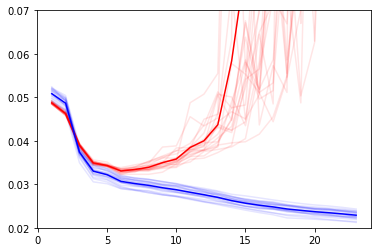

In [145]:
from franke_function import FrankeFunction as Fr
from regression import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 50) # lite: 50, stort: 500
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

poly = 24
n_bootstraps = 20
MSE_test_list = [] 
MSE_train_list = []
Predict_train_list = []

noise = np.random.randn(x.shape[0], x.shape[1])
z = Fr(x, y) + noise*0.18 # multiply with degree of noice. 
    
scaler = StandardScaler() # Scaling does not affect OLS, but it does affect bootstrap 
x_cent = x.reshape(-1, 1) #scaler.fit_transform(x.reshape(-1, 1)) 
y_cent = y.reshape(-1, 1) #scaler.fit_transform(y.reshape(-1, 1)) 
z_cent = z.reshape(-1, 1) #scaler.fit_transform(z.reshape(-1, 1))

xy_cent_train, xy_cent_test, z_cent_train, z_cent_test = train_test_split(np.hstack([x_cent, y_cent]),
                                                                          z_cent, test_size=0.2)

for n in range(n_bootstraps): 
    print("We are bootstrapping out of the depths! Now on number: " + str(n) + '/' + str(n_bootstraps))
    MSE_test = []
    MSE_train = []
    Predict_train = []
    
    #draw n samples from train set and compare with test set:
    n = z_cent_train.size #number of observations in train
    samples_nr = np.random.randint(0,n,n)
    xy_samp = xy_cent_train[samples_nr, :]
    z_samp = z_cent_train[samples_nr, :]
    
    for poly_deg in range(1, poly):
        model = OLS(xy_samp[:, 0].ravel(), xy_samp[:, 1].ravel(), z_samp.ravel(), poly_deg)
        
        Predict_train.append(model.predict(xy_samp[:, 0], xy_samp[:, 1]))
        MSE_test.append(model.MSE(xy_cent_test[:, 0], xy_cent_test[:, 1], z_cent_test.ravel()))
        MSE_train.append(model.MSE(xy_samp[:, 0], xy_samp[:, 1], z_samp.ravel())) # orig model.
    
    plt.plot(range(1, len(MSE_test)+1), MSE_test, 'r', alpha=0.1) 
    plt.plot(range(1, len(MSE_test)+1), MSE_train, 'b', alpha=0.1) 
    
    MSE_test_list.append(MSE_test) # sore all values for averaging
    MSE_train_list.append(MSE_train)
    Predict_train_list.append(Predict_train)
    
MSE_test_list = np.array(MSE_test_list)
MSE_train_list = np.array(MSE_train_list)

test_pol_avrg = np.mean(MSE_test_list, axis=0)
train_pol_avrg = np.mean(MSE_train_list, axis=0)

test_std = np.sqrt(np.var(MSE_test_list, axis=0)) #sqrt(variance), for hvert polynom, beregn variansen
train_std = np.sqrt(np.var(MSE_train_list, axis=0))

plt.plot(range(1, len(MSE_test)+1), test_pol_avrg, 'r')
plt.plot(range(1, len(MSE_test)+1), train_pol_avrg, 'b')

plt.ylim(0.02, 0.07)
plt.show()
# Observasjonar: 
# I Plottet under: Trekker ulike samples fra datasettet (med tilbakelegging) og predikerer optimal fit for ulike 
# polynomer med grad p. 

# I eksempelet over brukte eg ulike seed-verdier for å lage ulike utfall av støy. 
# I dette eksempelet viser me at det er mulig å modellere usikkerheit med  

In [146]:
noise = np.random.randn(x.shape[0], x.shape[1]) # normalfordelt støy. 
np.var(Fr(x, y)) # variansen til Fr, kor mykje den er over og under sitt gjennomsnitt. 
# eg skalerer jo data? 
print('Varians lagt til data: ' + str(np.var(noise*np.var(Fr(x, y))*2))) #støy som legges til modellen. Irreducible.
print('Tilsvarer std avvik: ' + str(np.sqrt(np.var(noise*np.var(Fr(x, y))*2))))
# beregnes som gjennomsnittlig (modell - virkelighet) ** 2 
print('Varians i franke: ' + str(np.var(Fr(x, y))))

Varians lagt til data: 0.028120215334496858
Tilsvarer std avvik: 0.16769083258931258
Varians i franke: 0.08214523455598685


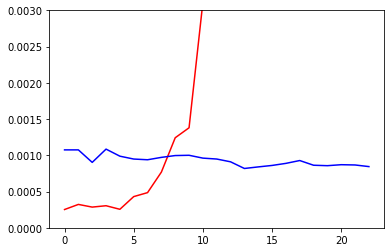

In [147]:
plt.plot(test_std, 'r')
plt.plot(train_std, 'b')
plt.ylim(0, 0.003)
plt.show()
# Observasjon: gjennomsnittlig avvik i MSE for treningsdata ser ut til å flate ut. 
# Dette setemmer bra overens med det vi observerer i plottet over. Den flater ut omtrent der feilen i test ser ut
# til å begynne å vokse også. 

In [148]:
# studerer spredning i estimater på en ekstremt krevende måte... 
poly_list = [[] for _ in range(len(Predict_train_list[0]))]
for bootstrap_nr in range(len(Predict_train_list)):
    for poly_degree_nr in range(len(Predict_train_list[bootstrap_nr])):
        poly_list[poly_degree_nr].append(Predict_train_list[bootstrap_nr][poly_degree_nr]) 

# poly_list inneholder nå alle forsøk på å gjette y i alle punkter, sortert etter polynom-grad.

mean_z = []
var_z = []
for pol in poly_list:
    pol = np.array(pol)
    mean_z.append(np.mean(pol))
    var_z.append(np.mean(np.var(pol, axis=0)))     

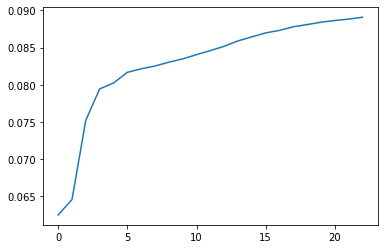

In [150]:
plt.plot(var_z)
plt.show()

In [ ]:
# Observasjon, nærmer seg jo forsåvidt 2*standardavvik støy som vi la til modellen. 